In [1]:
#coding:utf8
import os
import torch
from PIL import Image
from torch.utils import data
import numpy as np
from torchvision import  transforms as T
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import *
from torch.utils import data
from torchvision import transforms
from torchvision.models import vgg16,vgg19,resnet152,inception_v3
import torch.nn as nn
import datetime
from torchsummary import summary
import scipy

In [2]:
class DogCat(data.Dataset):
    def __init__(self,root,transforms=None,train=True,test=False):
        self.test = test
        imgs = [os.path.join(root,img) for img in os.listdir(root)] 
        # test1: data/test1/8973.jpg
        # train: data/train/cat.10004.jpg 
        if self.test:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2].split('\\')[-1]))
        else:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2]))  
        imgs_num = len(imgs)
        np.random.seed(100)
        self.imgs = imgs
        if transforms is None:
            if self.test or not train: 
                self.transforms = T.Compose([
                    T.CenterCrop(224),                            
                    T.ToTensor(),                
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ]) 
            else :
                imgs = np.random.permutation(imgs)
                self.transforms = T.Compose([
                    T.CenterCrop(224),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ])  
    def __getitem__(self,index):
        '''
        一次返回一张图片的数据
        '''
        img_path = self.imgs[index]
        if self.test: label = int(self.imgs[index].split('.')[-2].split('\\')[-1])
        else: label = 1 if 'dog' in img_path.split('\\')[-1] else 0
        data = Image.open(img_path)
        data = self.transforms(data)
        return data, label    
    def __len__(self):
        return len(self.imgs)

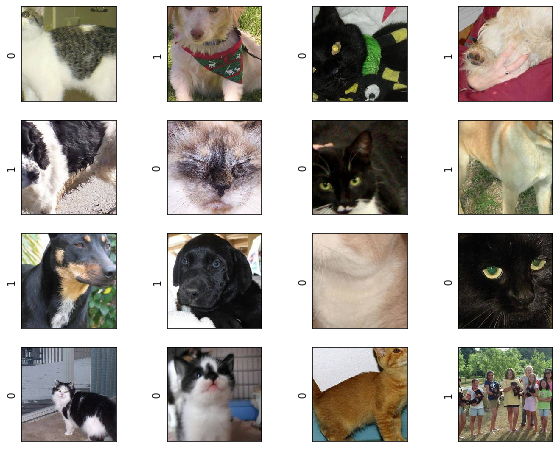

In [3]:
# 1=dog 0=cat
path = r'C:\Users\caeit\Desktop\binru7_1\train'
train_data = DogCat(path,train=True)
train_dataloader = DataLoader(train_data,batch_size=16,shuffle=True)
x,y = next(iter(train_dataloader))
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(10,8))
for j,i in enumerate(x):
    i = torch.transpose(i,2, 0)
    i = torch.transpose(i,0, 1)
    plt.subplot(4,4,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(y.data.numpy()[j])
    plt.imshow(i*std+mean)
    

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
model = resnet152()
model.fc = nn.Linear(2048,2)
model = model.cuda()
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
cost = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)

start = datetime.datetime.now()
for i in range(20):
        correct = 0.0
        total = 25000
        running_loss = 0.0
        accuracy = 0.0
        print('-----epoch', i+1, '-----')
        for num, image in enumerate(train_dataloader):
            x_train, y_train = image
            x_train = x_train.cuda()
            y_train = y_train.cuda()
            optimizer.zero_grad()
            output = model(x_train)
            loss = cost(output, y_train)
            _, predicted = torch.max(output, 1)
            correct += (predicted == y_train).sum().item()
            #print(correct)
            if num%100 == 0:
                print(num*16, '/ 25000', 'loss:', running_loss, ',accuracy:{}%'.format((100*correct/25000)),'correct:%s'%correct)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('-----------Epoch:', i+1, ', one_epoch_loss:', running_loss, '-----------',',accuracy:%f'%(100*correct/25000))
print(datetime.datetime.now()-start)
torch.save(model, '../fine_tuning_20_epoch_dog_cat_resnet152.pkl')

-----epoch 1 -----
0 / 25000 loss: 0.0 ,accuracy:0.036% correct:9.0
1600 / 25000 loss: 45.08551576733589 ,accuracy:5.58% correct:1395.0
3200 / 25000 loss: 68.11861547082663 ,accuracy:11.672% correct:2918.0
4800 / 25000 loss: 84.53706019744277 ,accuracy:17.828% correct:4457.0
6400 / 25000 loss: 99.08813185244799 ,accuracy:23.968% correct:5992.0
8000 / 25000 loss: 112.6633283495903 ,accuracy:30.064% correct:7516.0
9600 / 25000 loss: 123.98945792391896 ,accuracy:36.264% correct:9066.0
11200 / 25000 loss: 134.3225628696382 ,accuracy:42.46% correct:10615.0
12800 / 25000 loss: 142.63850501924753 ,accuracy:48.708% correct:12177.0
14400 / 25000 loss: 151.74130553007126 ,accuracy:54.928% correct:13732.0
16000 / 25000 loss: 159.6200619712472 ,accuracy:61.156% correct:15289.0
17600 / 25000 loss: 168.4640612192452 ,accuracy:67.348% correct:16837.0
19200 / 25000 loss: 176.62701215595007 ,accuracy:73.572% correct:18393.0
20800 / 25000 loss: 184.38080905377865 ,accuracy:79.78% correct:19945.0
22400 /

19200 / 25000 loss: 26.03358314372599 ,accuracy:76.304% correct:19076.0
20800 / 25000 loss: 27.811692090705037 ,accuracy:82.664% correct:20666.0
22400 / 25000 loss: 30.016727313399315 ,accuracy:89.02% correct:22255.0
24000 / 25000 loss: 32.39203765243292 ,accuracy:95.364% correct:23841.0
-----------Epoch: 7 , one_epoch_loss: 33.201807633042336 ----------- ,accuracy:99.284000
-----epoch 8 -----
0 / 25000 loss: 0.0 ,accuracy:0.064% correct:16.0
1600 / 25000 loss: 2.008552359417081 ,accuracy:6.42% correct:1605.0
3200 / 25000 loss: 4.337215172126889 ,accuracy:12.76% correct:3190.0
4800 / 25000 loss: 6.105459911748767 ,accuracy:19.124% correct:4781.0
6400 / 25000 loss: 7.849640019237995 ,accuracy:25.492% correct:6373.0
8000 / 25000 loss: 10.252558881416917 ,accuracy:31.84% correct:7960.0
9600 / 25000 loss: 12.488809367641807 ,accuracy:38.192% correct:9548.0
11200 / 25000 loss: 14.208059595897794 ,accuracy:44.536% correct:11134.0
12800 / 25000 loss: 15.81402013078332 ,accuracy:50.904% correc

11200 / 25000 loss: 4.439381031319499 ,accuracy:44.784% correct:11196.0
12800 / 25000 loss: 5.248228307813406 ,accuracy:51.156% correct:12789.0
14400 / 25000 loss: 6.037348119542003 ,accuracy:57.544% correct:14386.0
16000 / 25000 loss: 6.984271794557571 ,accuracy:63.92% correct:15980.0
17600 / 25000 loss: 8.15615938603878 ,accuracy:70.3% correct:17575.0
19200 / 25000 loss: 9.629023173823953 ,accuracy:76.676% correct:19169.0
20800 / 25000 loss: 10.368131944909692 ,accuracy:83.06% correct:20765.0
22400 / 25000 loss: 11.224925050511956 ,accuracy:89.444% correct:22361.0
24000 / 25000 loss: 11.770307777449489 ,accuracy:95.84% correct:23960.0
-----------Epoch: 14 , one_epoch_loss: 11.962983595207334 ----------- ,accuracy:99.772000
-----epoch 15 -----
0 / 25000 loss: 0.0 ,accuracy:0.064% correct:16.0
1600 / 25000 loss: 0.35503555834293365 ,accuracy:6.464% correct:1616.0
3200 / 25000 loss: 1.2305721901357174 ,accuracy:12.844% correct:3211.0
4800 / 25000 loss: 1.7274058125913143 ,accuracy:19.24

C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type "

In [12]:
model = torch.load('../fine_tuning_20_epoch_dog_cat_resnet152.pkl')
model = model.cuda()

path = r'C:\Users\caeit\Desktop\binru7_1\test1'
test_data = DogCat(path,train=False,test=True)
test_dataloader = DataLoader(test_data,batch_size=16,shuffle=False,num_workers=0)

result = []
start = datetime.datetime.now()
for num, image in enumerate(test_dataloader):
    x_train, y_train = image
    x_train = x_train.cuda()
    y_train = y_train.cuda()

    output = model(x_train)

    _, predicted = torch.max(output, 1)
    result.append(predicted)
print(datetime.datetime.now()-start)
result1 = []
for i in result:
    i = i.cpu()
    for j in i.data.numpy():
        result1.append(j)


for j,i in enumerate(result1):
    if i == 0:
        result1[j] = 0.05
    else:
        result1[j] = 0.95
np.savetxt("resnet152.csv", result1, delimiter=',')

0:02:26.314546


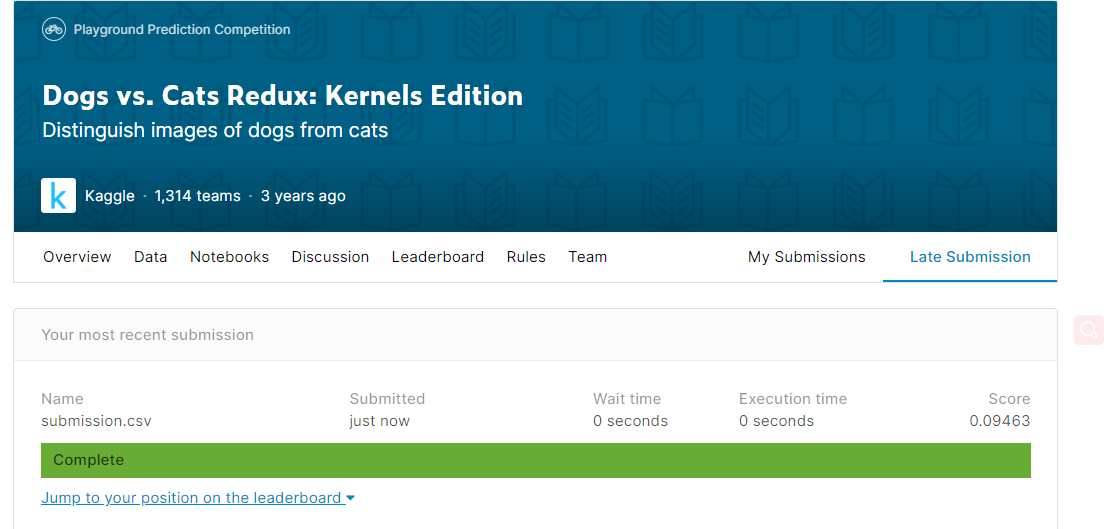